<link rel='stylesheet' href='../assets/css/main.css'/>

[<< back to main index](../README.md)

# Naive Bayes Spam Filtering

### Overview

We all hate spam, so developing a classifier to classify email as spam or not spam is useful.  

### Builds on
None

### Run time
approx. 20-30 minutes

### Notes

PySpark has a class called NaiveBayes that can be used to do Naive Bayes classification.

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/tmp/tmpwf6nthus
	some_property=some_value
Spark UI running on port 4046


## Step 1: Let's load the dataframe

We will load the dataframe into spark.  Since the outcome label is "ham" or "spam", we'll just call it label.

In [2]:
%%time

dataset = spark.read.format("csv").\
          option('header','true').\
          option('delimiter', '\t').\
          option('inferSchema', 'true').\
          load("/data/spam/SMSSpamCollection.txt")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.26 s


In [4]:
print("records count : {:,}".format(dataset.count()))

dataset.printSchema()
dataset.show(20, False)

records count : 5,574
root
 |-- isspam: string (nullable = true)
 |-- text: string (nullable = true)

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|isspam|text                                                                                                                                                                                                |
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ham   |Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                                                     |
|ham   |Ok lar... Joking wif u oni...                                     

In [5]:
## Count spam/ham
dataset.groupby("isspam").count().show()

+------+-----+
|isspam|count|
+------+-----+
|   ham| 4827|
|  spam|  747|
+------+-----+



## Step 2: Vectorize using tf/idf

Let's use tf/idf for vecorization at first.  TF/IDF will take and count the instances of each term, and then divide by the total frequecy of that term in the entire dataset.  

This leads to very highly dimensional data, because every word in the document will lead to a dimension in the data.

In [6]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

## TODO : split the text into words
## Hint : outputCol = 'words'
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(dataset)
wordsData.show()


+------+--------------------+--------------------+
|isspam|                text|               words|
+------+--------------------+--------------------+
|   ham|Go until jurong p...|[go, until, juron...|
|   ham|Ok lar... Joking ...|[ok, lar..., joki...|
|  spam|Free entry in 2 a...|[free, entry, in,...|
|   ham|U dun say so earl...|[u, dun, say, so,...|
|   ham|Nah I don't think...|[nah, i, don't, t...|
|  spam|FreeMsg Hey there...|[freemsg, hey, th...|
|   ham|Even my brother i...|[even, my, brothe...|
|   ham|As per your reque...|[as, per, your, r...|
|  spam|WINNER!! As a val...|[winner!!, as, a,...|
|  spam|Had your mobile 1...|[had, your, mobil...|
|   ham|I'm gonna be home...|[i'm, gonna, be, ...|
|  spam|SIX chances to wi...|[six, chances, to...|
|  spam|URGENT! You have ...|[urgent!, you, ha...|
|   ham|I've been searchi...|[i've, been, sear...|
|   ham|I HAVE A DATE ON ...|[i, have, a, date...|
|  spam|XXXMobileMovieClu...|[xxxmobilemoviecl...|
|   ham|Oh k...i'm watchi...|[o

In [8]:
## compute the hash of words

## we will tweak this later
number_of_features = 2000

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=number_of_features)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show()


+------+--------------------+--------------------+--------------------+--------------------+
|isspam|                text|               words|         rawFeatures|            features|
+------+--------------------+--------------------+--------------------+--------------------+
|   ham|Go until jurong p...|[go, until, juron...|(2000,[7,77,165,2...|(2000,[7,77,165,2...|
|   ham|Ok lar... Joking ...|[ok, lar..., joki...|(2000,[20,484,131...|(2000,[20,484,131...|
|  spam|Free entry in 2 a...|[free, entry, in,...|(2000,[30,128,140...|(2000,[30,128,140...|
|   ham|U dun say so earl...|[u, dun, say, so,...|(2000,[57,372,381...|(2000,[57,372,381...|
|   ham|Nah I don't think...|[nah, i, don't, t...|(2000,[388,426,89...|(2000,[388,426,89...|
|  spam|FreeMsg Hey there...|[freemsg, hey, th...|(2000,[68,91,98,9...|(2000,[68,91,98,9...|
|   ham|Even my brother i...|[even, my, brothe...|(2000,[47,48,57,2...|(2000,[47,48,57,2...|
|   ham|As per your reque...|[as, per, your, r...|(2000,[272,388,39...

In [9]:
rescaledData.select("isspam", "text", "features").show()

+------+--------------------+--------------------+
|isspam|                text|            features|
+------+--------------------+--------------------+
|   ham|Go until jurong p...|(2000,[7,77,165,2...|
|   ham|Ok lar... Joking ...|(2000,[20,484,131...|
|  spam|Free entry in 2 a...|(2000,[30,128,140...|
|   ham|U dun say so earl...|(2000,[57,372,381...|
|   ham|Nah I don't think...|(2000,[388,426,89...|
|  spam|FreeMsg Hey there...|(2000,[68,91,98,9...|
|   ham|Even my brother i...|(2000,[47,48,57,2...|
|   ham|As per your reque...|(2000,[272,388,39...|
|  spam|WINNER!! As a val...|(2000,[74,153,388...|
|  spam|Had your mobile 1...|(2000,[82,279,343...|
|   ham|I'm gonna be home...|(2000,[26,263,333...|
|  spam|SIX chances to wi...|(2000,[15,46,214,...|
|  spam|URGENT! You have ...|(2000,[68,196,388...|
|   ham|I've been searchi...|(2000,[39,185,317...|
|   ham|I HAVE A DATE ON ...|(2000,[44,82,712,...|
|  spam|XXXMobileMovieClu...|(2000,[78,273,388...|
|   ham|Oh k...i'm watchi...|(2

## Step 3: Create a numeric label out of the string column "isspam."

In [10]:
from pyspark.ml.feature import StringIndexer

## TODO : Index 'isspam' column into 'label' column
## Hint : inputCol = 'isspam',   outputCol = 'label'
indexer = StringIndexer(inputCol="isspam", outputCol="label")
indexed = indexer.fit(rescaledData).transform(rescaledData)

indexed.select(['text', 'isspam', 'label', 'features']).show()


+--------------------+------+-----+--------------------+
|                text|isspam|label|            features|
+--------------------+------+-----+--------------------+
|Go until jurong p...|   ham|  0.0|(2000,[7,77,165,2...|
|Ok lar... Joking ...|   ham|  0.0|(2000,[20,484,131...|
|Free entry in 2 a...|  spam|  1.0|(2000,[30,128,140...|
|U dun say so earl...|   ham|  0.0|(2000,[57,372,381...|
|Nah I don't think...|   ham|  0.0|(2000,[388,426,89...|
|FreeMsg Hey there...|  spam|  1.0|(2000,[68,91,98,9...|
|Even my brother i...|   ham|  0.0|(2000,[47,48,57,2...|
|As per your reque...|   ham|  0.0|(2000,[272,388,39...|
|WINNER!! As a val...|  spam|  1.0|(2000,[74,153,388...|
|Had your mobile 1...|  spam|  1.0|(2000,[82,279,343...|
|I'm gonna be home...|   ham|  0.0|(2000,[26,263,333...|
|SIX chances to wi...|  spam|  1.0|(2000,[15,46,214,...|
|URGENT! You have ...|  spam|  1.0|(2000,[68,196,388...|
|I've been searchi...|   ham|  0.0|(2000,[39,185,317...|
|I HAVE A DATE ON ...|   ham|  

## Step 4: Split into training and test

We will split our dataset into training and test sets.

In [11]:
# TODO : Split the data into train and test into 80/20
(train, test) = indexed.randomSplit([.8, .2])

print("training set count : ", train.count())
print("testing set count : ", test.count())

training set count :  4467
testing set count :  1107


## Step 5: Fit Naive Bayes model

In [12]:
from pyspark.ml.classification import NaiveBayes

## TODO : create the trainer and set its parameters
## Hint : NaiveBayes  (see the class name above)
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")


In [13]:
%%time

# train the model
print("training starting...")
## TODO : fit on training data (hint: train)
model = nb.fit(train)
print("training done.")

training starting...
training done.
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.62 s


## Step 6: Run test data

Let's call .transform on our model to do make predictions on our test data. The output should be contained in the "prediction" column, while the correct label will be there in the "label" column. 

We will be able to evaluate our results by comparing the results.

In [14]:
# select example rows to display.
## TODO : transform on test data (hint : test)
predictions_test = model.transform(test)
predictions_test.limit(5).toPandas()

,isspam,text,words,rawFeatures,features,label,rawPrediction,probability,prediction
0,ham,&lt;#&gt; mins but i had to stop somewhere f...,"[, &lt;#&gt;, , mins, but, i, had, to, stop, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-238.00008767518784, -247.69666065377143]","[0.9999385099060782, 6.149009392179112e-05]",0.0
1,ham,says that he's quitting at least5times a day ...,"[, says, that, he's, quitting, at, least5times...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-1023.6090481114477, -1135.7270521389526]","[1.0, 2.0312787669844803e-49]",0.0
2,ham,what number do u live at? Is it 11?,"[, what, number, do, u, live, at?, is, it, 11?]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-218.51217142825348, -256.8043472202413]","[1.0, 2.3437935430006354e-17]",0.0
3,ham,"""The world suffers a lot... Not because of the...","[""the, world, suffers, a, lot..., not, because...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-628.2650041623825, -658.7820364094598]","[0.9999999999999443, 5.579834156193721e-14]",0.0
4,ham,"""Wen u miss someone, the person is definitely ...","[""wen, u, miss, someone,, the, person, is, def...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.4288230189921...",0.0,"[-732.4819069852969, -768.2636553158575]","[0.9999999999999998, 2.8852546337894764e-16]",0.0


## Step 7: Evaluate the model

Let's look at how our model performs.  We will do an accuracy measure.

In [15]:
predictions_test = model.transform(test)  # hint : test
predictions_train = model.transform(train)  # hint : train

### 7.1 - Accuracy

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.9691067830758898
Test set accuracy =  0.9322493224932249


### 7.2 - Confusion Matrix

In [17]:
cm = predictions_test.groupBy('label').pivot('prediction', [0,1]).count().na.fill(0).orderBy('label')
cm.show()

## Can you explain the confusion matrix

+-----+---+---+
|label|  0|  1|
+-----+---+---+
|  0.0|911| 58|
|  1.0| 17|121|
+-----+---+---+



[]

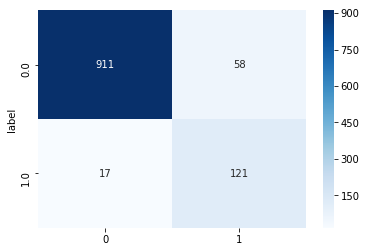

In [19]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("label", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, fmt=',', cmap="Blues").plot()

## Step 8: Improve prediction results

We used too few features above, and got bad accuracy. Increase the number of features for HashingTF.

in Step 2, modify the following line `number_of_features = 20`.  
Try the following values
- 200
- 2000
- and a large number 

For each value, record 
- training / testing accuracy
- and confusion matrix

Discuss your results in the class.

## Step 9:  Run your own test

Now it's your turn!   Make a new dataframe with some sample test data of your own creation.  Make some "spammy" SMSes and some ordinary ones.  See how our spam filter does.

In [24]:
# TODO: make a dataframe with some of your own data.
import pandas as pd

mydata = pd.DataFrame({'text' : ['hey, can we meet 1 hr later?', 
                                'WINNER!  Click here to claim your prize !!!!',
                                'CHEAP DEGREEES !!', 
                                'free food',
                                'freee food!']
                         })

mydata2 = spark.createDataFrame(mydata)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
fv = tokenizer.transform(mydata2)
fv.show()

## NOTE : make sure this 'numFeatures' matches the 'numFeatures' in step-2
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=2000)
fv = hashingTF.transform(fv)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
fv = idfModel.transform(fv)
fv.show()

+--------------------+--------------------+
|                text|               words|
+--------------------+--------------------+
|hey, can we meet ...|[hey,, can, we, m...|
|WINNER!  Click he...|[winner!, , click...|
|   CHEAP DEGREEES !!|[cheap, degreees,...|
|           free food|        [free, food]|
|         freee food!|      [freee, food!]|
+--------------------+--------------------+

+--------------------+--------------------+--------------------+--------------------+
|                text|               words|         rawFeatures|            features|
+--------------------+--------------------+--------------------+--------------------+
|hey, can we meet ...|[hey,, can, we, m...|(2000,[238,486,74...|(2000,[238,486,74...|
|WINNER!  Click he...|[winner!, , click...|(2000,[388,493,53...|(2000,[388,493,53...|
|   CHEAP DEGREEES !!|[cheap, degreees,...|(2000,[119,339,16...|(2000,[119,339,16...|
|           free food|        [free, food]|(2000,[653,1073],...|(2000,[653,1073],...|
|

In [25]:
predictions = model.transform(fv)
predictions.select(['text', 'prediction']).show()

+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|hey, can we meet ...|       0.0|
|WINNER!  Click he...|       1.0|
|   CHEAP DEGREEES !!|       0.0|
|           free food|       1.0|
|         freee food!|       0.0|
+--------------------+----------+



## FUN : How will you defeat this algorithm? :-) 

If you are spammer, how can you defeat this algorithm?

<img src="../assets/images/come-tothe-dark-side-iin-we-have-cookies.png">

## Further Reading
Checkout [Amazon Comprehend](https://us-west-2.console.aws.amazon.com/comprehend/v2/home?region=us-west-2#welcome) to parse natural text and extract meaning.

## BONUS: Word2Vec Instead of TF/IDF

We used the TF/IDF encoding. We might get better resu

lts if we use Word2Vec instead. Run with word2vec and see if you get a better accuracy rate.

Refer to [Spark Word2Vec](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html#word2vec) implementation for details